# 将Gated2Depth项目分解逐步处理

### 测试  


In [1]:
x = 257
while True:
    if (720 - x) % 16 == 0 and (1280 - x) % 64 == 0:
        break
    x += 1
    if x>500 :break
print(x)
# 400*960

320


In [2]:
#  Copyright 2018 Algolux Inc. All Rights Reserved.
#  修改自dataset_util.py
import os
import cv2
import numpy as np

crop_size = 160


# crop_size = 0


def read_gated_image(base_dir, gta_pass, img_id, data_type, num_bits=10, scale_images=False,
                     scaled_img_width=None, scaled_img_height=None,
                     normalize_images=False):
    gated_imgs = []
    normalizer = 2 ** num_bits - 1.

    for gate_id in range(3):
        gate_dir = os.path.join(base_dir, gta_pass, 'gated%d_10bit' % gate_id)
        img = cv2.imread(os.path.join(gate_dir, img_id + '.png'), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        if data_type == 'real':
            img = img[crop_size:(img.shape[0] - crop_size), crop_size:(img.shape[1] - crop_size)]
            img = img.copy()
            img[img > 2 ** 10 - 1] = normalizer
        img = np.float32(img / normalizer)
        gated_imgs.append(np.expand_dims(img, axis=2))

    img = np.concatenate(gated_imgs, axis=2)
    if normalize_images:
        mean = np.mean(img, axis=2, keepdims=True)
        std = np.std(img, axis=2, keepdims=True)
        img = (img - mean) / (std + np.finfo(float).eps)
    if scale_images:
        img = cv2.resize(img, dsize=(scaled_img_width, scaled_img_height), interpolation=cv2.INTER_AREA)
    return np.expand_dims(img, axis=0)


def read_gt_image(base_dir, gta_pass, img_id, data_type, min_distance, max_distance, scale_images=False,
                  scaled_img_width=None,
                  scaled_img_height=None, raw_values_only=False):
    if data_type == 'real':
        depth_lidar1 = np.load(
            os.path.join(
                base_dir, gta_pass, "depth_hdl64_gated_compressed", 
                img_id + '.npz'))['arr_0']
        depth_lidar1 = depth_lidar1[crop_size: (depth_lidar1.shape[0] - crop_size),
                       crop_size: (depth_lidar1.shape[1] - crop_size)]
        if raw_values_only:
            return depth_lidar1, None

        gt_mask = (depth_lidar1 > 0.)

        depth_lidar1 = np.float32(np.clip(depth_lidar1, min_distance, max_distance) / max_distance)

        # 数组的形状将变为(1, height, width, 1)
        return np.expand_dims(np.expand_dims(depth_lidar1, axis=2), axis=0), \
            np.expand_dims(np.expand_dims(gt_mask, axis=2), axis=0)
        # return depth_lidar1, gt_mask

    img = np.load(os.path.join(base_dir, gta_pass, 'depth_compressed', img_id + '.npz'))['arr_0']

    if raw_values_only:
        return img, None

    img = np.clip(img, min_distance, max_distance) / max_distance
    if scale_images:
        img = cv2.resize(img, dsize=(scaled_img_width, scaled_img_height), interpolation=cv2.INTER_AREA)

    return np.expand_dims(np.expand_dims(img, axis=2), axis=0), None

<Figure size 2000x2000 with 0 Axes>

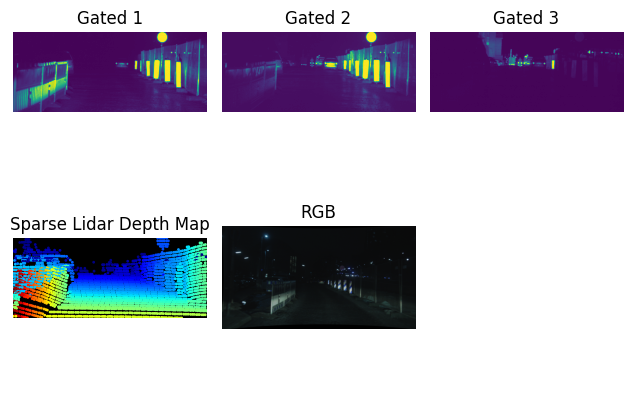

In [3]:
#测试数据读取

import matplotlib.pyplot as plt

base_dir = '../data/real'
gta_pass = ''
data_type = 'real'
img_id = '01151'
min_distance = 3.
max_distance = 150.

# 从数据文件中读取目标图像和激光雷达掩码
in_img = read_gated_image(base_dir, gta_pass, img_id, data_type)
gt_patch, lidar_mask = read_gt_image(base_dir, gta_pass, img_id, data_type, min_distance, max_distance,
                                     # raw_values_only=True
                                     )

# 测试保存concatenate后的数据
in_dir = '../data/real/gated'
depth_dir = '../data/real/depth'
np.save(in_dir +img_id +'.npy', in_img)
laod_in_img = np.load(in_dir +img_id +'.npy')


figShape = [720 - crop_size * 2, 1280 - crop_size * 2]
# 创建一个2x2的子图布局
plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 3)
# 在子图上绘图
axs[0, 0].set_title('Gated 1')
axs[0, 0].imshow(laod_in_img[:, :, :, 0:1].reshape(figShape))
axs[0, 0].axis('off')

axs[0, 1].set_title('Gated 2')
axs[0, 1].imshow(in_img[:, :, :, 1:2].reshape(figShape))
axs[0, 1].axis('off')

axs[0, 2].set_title('Gated 3')
axs[0, 2].imshow(in_img[:, :, :, 2:3].reshape(figShape))
axs[0, 2].axis('off')

y_coords, x_coords = np.where(lidar_mask.reshape(figShape))
valid_depths = np.where(lidar_mask, gt_patch, np.nan)
axs[1, 0].set_title('Sparse Lidar Depth Map')
axs[1, 0].imshow(np.zeros_like(gt_patch.reshape(figShape)), cmap='gray')
axs[1, 0].scatter(x_coords, y_coords, c=1./(gt_patch.reshape(figShape)[lidar_mask.reshape(figShape)]), cmap='jet', s=1, marker='o')
axs[1, 0].axis('off')

RGBimg = cv2.imread(os.path.join(base_dir,'rgb_left_8bit' ,img_id + '.png'))
axs[1, 1].set_title('RGB')
axs[1, 1].imshow(RGBimg)
axs[1, 1].axis('off')
axs[1, 2].axis('off')
# 调整子图之间的间距
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np

base_dir = '../data/real'
gta_pass = ''
data_type = 'real'
img_id = '01151'
min_distance = 3.
max_distance = 150.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

data_dir = '../data/real'
sample_ids = [f.split('.')[0] for f in os.listdir(os.path.join(data_dir, 'gated0_10bit'))]

def load_sample(sample_id):
    if isinstance(sample_id, tf.Tensor):
        sample_id = sample_id.numpy().decode('utf-8')
    input1_path = os.path.join(data_dir, 'gated0_10bit', sample_id + '.png')
    input2_path = os.path.join(data_dir, 'gated1_10bit', sample_id + '.png')
    input3_path = os.path.join(data_dir, 'gated2_10bit', sample_id + '.png')
    depth_path = os.path.join(data_dir, 'depth_hdl64_gated_compressed', sample_id + '.npz')
    
    # 设置阈值和normalizer
    threshold = 2 ** 10 - 1
    normalizer_value = 2 ** 10 - 1
    # 设置裁剪大小
    crop_size = 160
    
    input1 = tf.image.decode_png(tf.io.read_file(input1_path), channels=1)
    input1 = tf.cast(input1, tf.float32)
    # 获取图像的高度和宽度
    height, width, _ = input1.shape
    # 使用tf.image.crop_to_bounding_box裁剪图像
    input1 = tf.image.crop_to_bounding_box(input1, crop_size, crop_size, 
                                           height - 2*crop_size, width - 2*crop_size)
    normalizer = tf.constant(normalizer_value, dtype=tf.float32)
    # 使用tf.where处理大于阈值的像素
    img_tensor = tf.where(input1 > threshold, normalizer, input1)
    # 将图像张量转换为float32并除以normalizer
    input1 = tf.cast(img_tensor, tf.float32) / normalizer
    
    
    input2 = tf.image.decode_png(tf.io.read_file(input2_path), channels=1)
    input2 = tf.cast(input2, tf.float32)
    # 获取图像的高度和宽度
    height, width, _ = input2.shape
    # 使用tf.image.crop_to_bounding_box裁剪图像
    input2 = tf.image.crop_to_bounding_box(input2, crop_size, crop_size, 
                                           height - 2*crop_size, width - 2*crop_size)
    normalizer = tf.constant(normalizer_value, dtype=tf.float32)
    # 使用tf.where处理大于阈值的像素
    img_tensor = tf.where(input2 > threshold, normalizer, input2)
    # 将图像张量转换为float32并除以normalizer
    input2 = tf.cast(img_tensor, tf.float32) / normalizer
    
    
    input3 = tf.image.decode_png(tf.io.read_file(input3_path), channels=1)
    input3 = tf.cast(input3, tf.float32)
    # 获取图像的高度和宽度
    height, width, _ = input3.shape
    # 使用tf.image.crop_to_bounding_box裁剪图像
    input3 = tf.image.crop_to_bounding_box(input3, crop_size, crop_size, 
                                           height - 2*crop_size, width - 2*crop_size)
    normalizer = tf.constant(normalizer_value, dtype=tf.float32)
    # 使用tf.where处理大于阈值的像素
    img_tensor = tf.where(input3 > threshold, normalizer, input3)
    # 将图像张量转换为float32并除以normalizer
    input3 = tf.cast(img_tensor, tf.float32) / normalizer
    
    depth = np.load(depth_path)['arr_0']
    depth = depth[crop_size: (depth.shape[0] - crop_size), crop_size: (depth.shape[1] - crop_size)]
    depth = np.float32(np.clip(depth, min_distance, max_distance) / max_distance)
    depth = np.expand_dims(depth, axis=2) #改为[height, width, 1]
    gt_mask = (depth > 0.02)
    y_true_with_mask = tf.concat([depth, gt_mask], axis=-1)
    
    inputs = tf.stack([input1, input2, input3], axis=-1)
    inputs = tf.squeeze(inputs, axis=-2) #将数据形状更改为[height, width, 3],以适应网络
    return inputs, y_true_with_mask

inputs1, depth1 = load_sample(sample_ids[25])


dataset = tf.data.Dataset.from_tensor_slices(sample_ids)
dataset = dataset.map(
    lambda x: tf.py_function(
        load_sample, [x], [tf.float32, tf.float32]), 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

# dataset = (dataset.shuffle(1024).batch(4).prefetch(tf.data.experimental.AUTOTUNE))
dataset = (dataset.shuffle(1024).batch(2))

In [2]:
#测试unet
import unet
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                                [tf.config.experimental.VirtualDeviceConfiguration(
                                                                    memory_limit=10096)])
    except RuntimeError as e:
        print(e)

# 测试
input_img = tf.keras.Input(shape=(400, 960, 3))
# input_img = tf.keras.Input(shape=(720, 1280, 3))
model = tf.keras.Model(inputs=input_img, outputs=unet.build_unet(input_img))

def custom_l1_loss(y_true, y_pred):
    tf.print(" Shape of y_true:", tf.shape(y_true))
    tf.print(" Shape of y_pred:", tf.shape(y_pred))
    # 假设y_true的最后一个通道是gt_mask
    gt_mask = y_true[..., -1:]
    y_true = y_true[..., :-1]  # 移除gt_mask以得到真实的y_true

    loss = tf.reduce_sum(tf.abs(y_pred - y_true) * gt_mask) / (tf.reduce_sum(gt_mask) + 1e-8)
    return loss

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=custom_l1_loss)
model.summary()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Virtual devices cannot be modified after being initialized
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 960, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 960, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 400, 960, 32  9248        ['

In [3]:

history = model.fit(dataset,
          epochs=3,
          batch_size=2)

Epoch 1/3


InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  ValueError: Tensor's shape (0, 400, 960, 1) is not compatible with supplied shape [1, 400, 960, 1].
Traceback (most recent call last):

  File "C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\edric\AppData\Local\Temp\ipykernel_30800\3389137651.py", line 43, in load_sample
    input1 = tf.image.crop_to_bounding_box(input1, crop_size, crop_size,

  File "C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\tensorflow\python\framework\ops.py", line 1301, in set_shape
    raise ValueError(f"Tensor's shape {self.shape} is not compatible "

ValueError: Tensor's shape (0, 400, 960, 1) is not compatible with supplied shape [1, 400, 960, 1].


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[custom_l1_loss/Rank_1/_10]]
  (1) INVALID_ARGUMENT:  ValueError: Tensor's shape (0, 400, 960, 1) is not compatible with supplied shape [1, 400, 960, 1].
Traceback (most recent call last):

  File "C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\edric\AppData\Local\Temp\ipykernel_30800\3389137651.py", line 43, in load_sample
    input1 = tf.image.crop_to_bounding_box(input1, crop_size, crop_size,

  File "C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\tensorflow\python\framework\ops.py", line 1301, in set_shape
    raise ValueError(f"Tensor's shape {self.shape} is not compatible "

ValueError: Tensor's shape (0, 400, 960, 1) is not compatible with supplied shape [1, 400, 960, 1].


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3480]

In [9]:
history.history['loss']


[0.05532503128051758, 0.041890356689691544, 0.03971921652555466]

In [12]:
model.save_weights('newG2D-weight_02.h5')

1/1 [==============================] - 0s 23ms/step
(720, 1280)


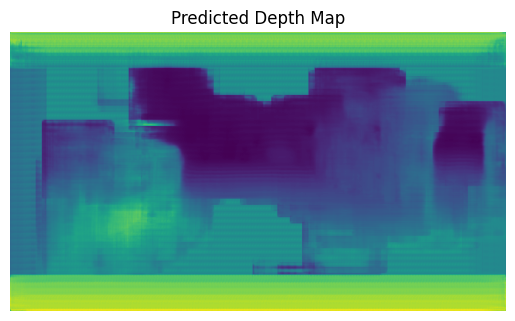

In [48]:
# 假设你想预测的样本的ID是"sample_id_to_predict"

# 使用你的load_sample函数加载样本
inputs, _ = load_sample(img_id)

# 扩展数据的维度以匹配模型的输入维度
inputs = tf.expand_dims(inputs, axis=0)

# 使用模型进行预测
predictions = model.predict(inputs)

# 输出预测结果
# 获取预测的深度图
predicted_depth = predictions[0, :, :, 0]  # 假设预测结果的形状为 [batch_size, height, width, channels]，并且你只关心第一个通道
print(predicted_depth.shape)
# 使用matplotlib显示图像
plt.imshow(1./predicted_depth, cmap='viridis')  # 使用viridis颜色映射，你可以选择其他的
# plt.colorbar()
plt.title("Predicted Depth Map")
plt.axis('off')
plt.show()

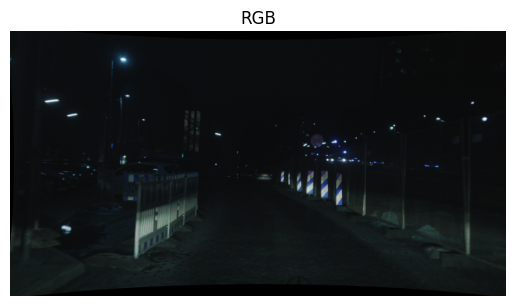

In [49]:
plt.title('RGB')
plt.imshow(RGBimg)
plt.axis('off')
plt.show()

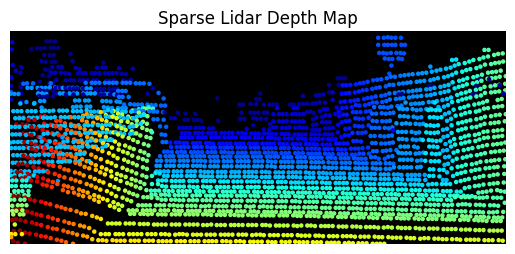

In [52]:
plt.title('Sparse Lidar Depth Map')
plt.imshow(np.zeros_like(gt_patch.reshape(figShape)), cmap='gray')
plt.scatter(x_coords, y_coords, c=1./(gt_patch.reshape(figShape)[lidar_mask.reshape(figShape)]), cmap='jet', s=5, marker='o')
plt.axis('off')
plt.show()